In [1]:
#loading all the needed libraries
import os
import json
import math
import numpy as np
import pandas as pd
import random
from bokeh.io import output_file, show , output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource,  LabelSet
from bokeh.palettes import Viridis256,all_palettes,BrBG, PiYG, RdGy, RdYlGn, YlGnBu, PuBuGn, Colorblind, Bokeh,Category20,Accent
import matplotlib.pyplot as plt
import seaborn as sn

import cv2
from PIL import Image
from tqdm.auto import tqdm, trange
import glob
import re
from pynvml import *
from datetime import datetime

import torchvision,torch
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch.nn.functional as F
from torchvision import models
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils import class_weight

from torchsummary import summary
import adabound
import scikitplot as skplt

In [25]:
# This class provides utility functions to work with the pre processing of the video
class PreprocessVideo():
    
    def __init__(self, dataframe, 
                 source_root , 
                 dest_root , 
                 fps = 30, cropSize = (112,112), dest_ext = ".avi", source_ext = ".mp4"):
        self.pid_list = dataframe['fileID'].values
        self.videofile_list = dataframe['PLAX_video_path'].values
        self.fps = fps
        self.cropSize = cropSize
        self.source_ext =  source_ext
        self.dest_ext = dest_ext
        self.source_video_path = []
        self.dest_video_path = []
        self.source_root = source_root
        self.dest_root = dest_root

        for i in range(len(dataframe)):
            video_id = self.pid_list[i]
            source_path = os.path.join(self.source_root, str(video_id), self.videofile_list[i] + self.source_ext)
            dest_path = os.path.join(self.dest_root, self.videofile_list[i] + self.dest_ext)
            self.source_video_path.append(source_path)
            self.dest_video_path.append(dest_path)
            
        
    def mask(self, output):
        dimension = output.shape[0]
        m1, m2 = np.meshgrid(np.arange(dimension), np.arange(dimension))
        mask = ((m1+m2)>int(dimension/2) + int(dimension/10)) 
        mask *=  ((m1-m2)<int(dimension/2) + int(dimension/10))
        mask = np.reshape(mask, (dimension, dimension)).astype(np.int8)
        maskedImage = cv2.bitwise_and(output, output, mask = mask)
        return maskedImage
    
    def getFrames(self, filename):
        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))  
        allFrames = []
        for fn in range(v_len):
            success, frame = v_cap.read()
            if success is False:
                continue
            allFrames.append(frame)
        v_cap.release()
        return allFrames
    
    def makeVideo(self, sourceFolder, destFolder):
        testarray = self.getFrames(sourceFolder)
        testarray = np.array(testarray)
        #print(testarray.shape,sourceFolder)
        frame0 = testarray[0]
        mean = np.mean(frame0, axis=1)
        mean = np.mean(mean, axis=1)
        yCrop = np.where(mean<1)[0][0]
        #print(testarray.shape)
        testarray = testarray[:, yCrop:, :, :]

        bias = int(np.abs(testarray.shape[2] - testarray.shape[1])/2)
        if bias>0:
            if testarray.shape[1] < testarray.shape[2]:
                testarray = testarray[:, :, bias:-bias, :]
            else:
                testarray = testarray[:, bias:-bias, :, :]


        #print(testarray.shape)
        frames,height,width,channels = testarray.shape

        fps = self.fps
        fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
        out = cv2.VideoWriter(destFolder, fourcc, self.fps, self.cropSize)

        for i in range(frames):

            outputA = testarray[i,:,:,0]
            smallOutput = outputA[int(height/10):(height - int(height/10)), int(height/10):(height - int(height/10))]
            output = cv2.resize(smallOutput, self.cropSize, interpolation = cv2.INTER_CUBIC)
            finaloutput = self.mask(output)

            finaloutput = cv2.merge([finaloutput,finaloutput,finaloutput])
            out.write(finaloutput)

        out.release()
        
    def runProcess(self, sanity_check = False):
        for i in tqdm(range(len(self.source_video_path))):
            if(sanity_check):
                continue
            self.makeVideo(self.source_video_path[i],self.dest_video_path[i])

# Creating the data for the model

## Creating the .avi files for the data

In [61]:
#loading the data of Alberta Heart which consists of only the patient ID's that have PLAX data.
AlbertaData = pd.read_csv('../AlbertaHeart/Generated_csv_files/AlbertaData_Mortality_PLAX_all.csv')
AlbertaData = AlbertaData.drop(['Unnamed: 0'],axis=1)

In [63]:
#running the class function
source_root = "../AlbertaHeart/data/PLAX/"
dest_root = "../AlbertaHeart/video/"
Alberta_video = PreprocessVideo(AlbertaData, source_root, dest_root)
Alberta_video.runProcess(True)

  0%|          | 0/997 [00:00<?, ?it/s]

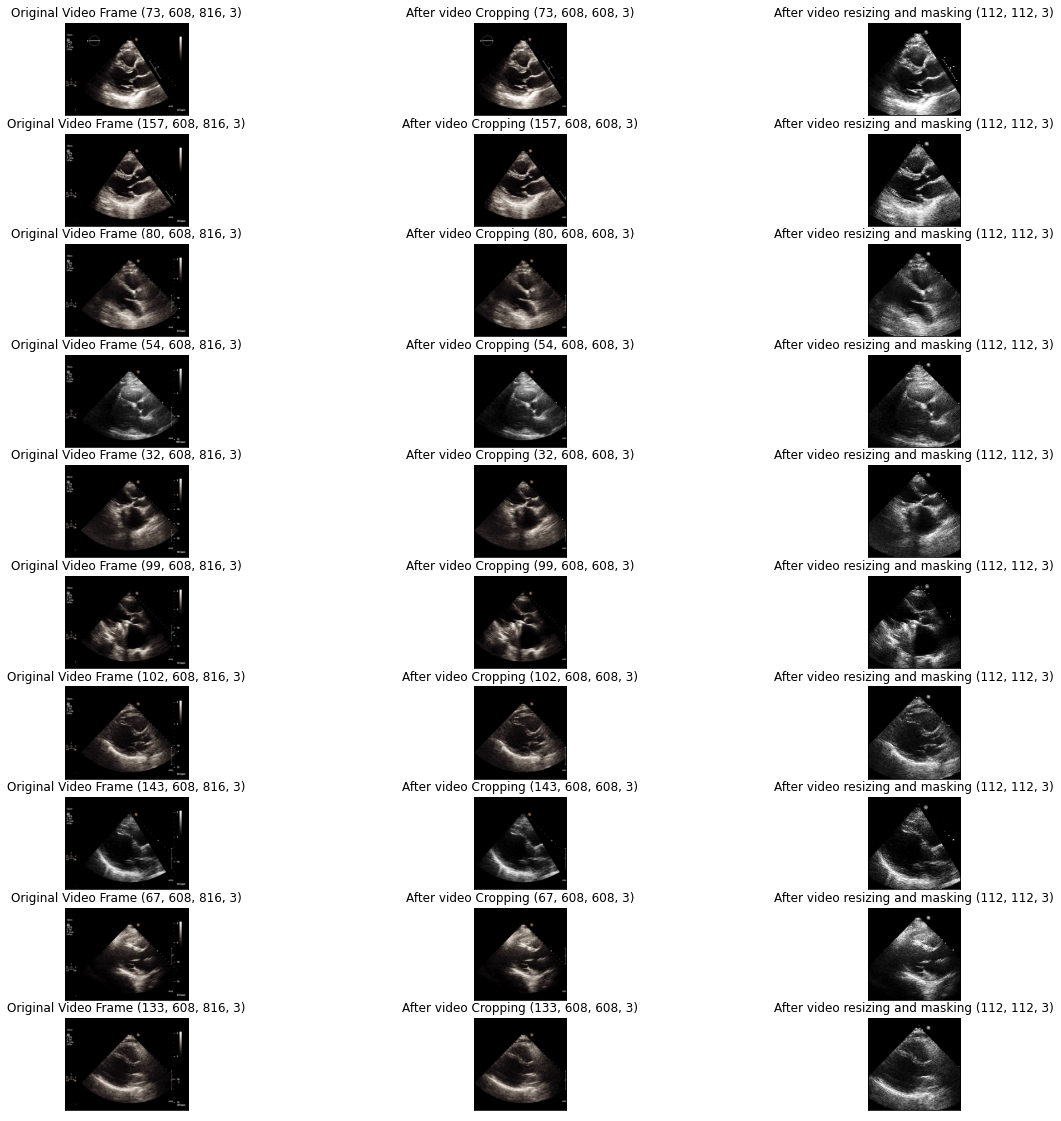

In [65]:
#showing an example of the frames extracted , in this case example it shows 30 . 
plt.figure(figsize=(20, 20))
cropSize = (112,112)
count = 1
for i in range(10,20):
    plt.subplot(10, 3, count, xticks=[], yticks=[])
    frames = Alberta_video.getFrames(Alberta_video.source_video_path[i])

    testarray = np.array(frames)
    frame0 = testarray[0]
    count+=1
    img = Image.fromarray(frame0, 'RGB')
    img = np.array(img)
    plt.imshow(img)
    plt.title('Original Video Frame ' + str(testarray.shape))

    mean = np.mean(frame0, axis=1)
    mean = np.mean(mean, axis=1)
    yCrop = np.where(mean<1)[0][0]

    testarray = testarray[:, yCrop:, :, :]
    bias = int(np.abs(testarray.shape[2] - testarray.shape[1])/2)

    if bias>0:
        if testarray.shape[1] < testarray.shape[2]:
            testarray = testarray[:, :, bias:-bias, :]
        else:
            testarray = testarray[:, bias:-bias, :, :]

    frames,height,width,channels = testarray.shape

    img = Image.fromarray(testarray[0], 'RGB')
    img = np.array(img)
    plt.subplot(10, 3, count, xticks=[], yticks=[])
    plt.imshow(img)
    plt.title('After video Cropping ' + str(testarray.shape))
    count+=1
    for i in range(frames):
        outputA = testarray[i,:,:,0]
        smallOutput = outputA[int(height/10):(height - int(height/10)), int(height/10):(height - int(height/10))]
        output = cv2.resize(smallOutput, cropSize, interpolation = cv2.INTER_CUBIC)
        finaloutput = Mackay_video.mask(output)
        finaloutput = cv2.merge([finaloutput,finaloutput,finaloutput])
        if(i==0):
            firstimage = finaloutput

    img = np.array(firstimage)
    plt.subplot(10, 3, count, xticks=[], yticks=[])
    count+=1
    plt.imshow(img)
    plt.title('After video resizing and masking ' + str(finaloutput.shape))

In [55]:
total_folders = 0
print("total video files is",len(os.listdir("../AlbertaHeart/video/")))

total video files is 997
